# 2.3.1. Загрузка данных и первичный анализ

## Импорт библиотек

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (accuracy_score, roc_auc_score, precision_score, 
                           recall_score, f1_score, confusion_matrix, 
                           classification_report, roc_curve, auc)
import warnings
warnings.filterwarnings('ignore')

# Настройка отображения графиков.
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
%matplotlib inline

## Загрузка данных

In [19]:
data = pd.read_csv('./data/S05-hw-dataset.csv')
print("Размер датасета:", data.shape)
print("\nПервые 5 строк:")
print(data.head())

Размер датасета: (3000, 17)

Первые 5 строк:
   client_id  age  income  years_employed  credit_score  debt_to_income  \
0          1   25   94074              22           839        0.547339   
1          2   58   51884              26           565        0.290882   
2          3   53   48656              39           561        0.522340   
3          4   42   81492              30           582        0.709123   
4          5   42   94713               8           642        0.793392   

   num_credit_cards  num_late_payments  has_mortgage  has_car_loan  \
0                 1                  7             0             0   
1                 1                  1             0             1   
2                 1                 13             0             0   
3                 2                 10             1             1   
4                 3                  3             0             0   

   savings_balance  checking_balance  region_risk_score  \
0            26057      

## Первичный анализ данных

Информация о датасете:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000 entries, 0 to 2999
Data columns (total 17 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   client_id                       3000 non-null   int64  
 1   age                             3000 non-null   int64  
 2   income                          3000 non-null   int64  
 3   years_employed                  3000 non-null   int64  
 4   credit_score                    3000 non-null   int64  
 5   debt_to_income                  3000 non-null   float64
 6   num_credit_cards                3000 non-null   int64  
 7   num_late_payments               3000 non-null   int64  
 8   has_mortgage                    3000 non-null   int64  
 9   has_car_loan                    3000 non-null   int64  
 10  savings_balance                 3000 non-null   int64  
 11  checking_balance                3000 non-null   int64  
 12  region_risk

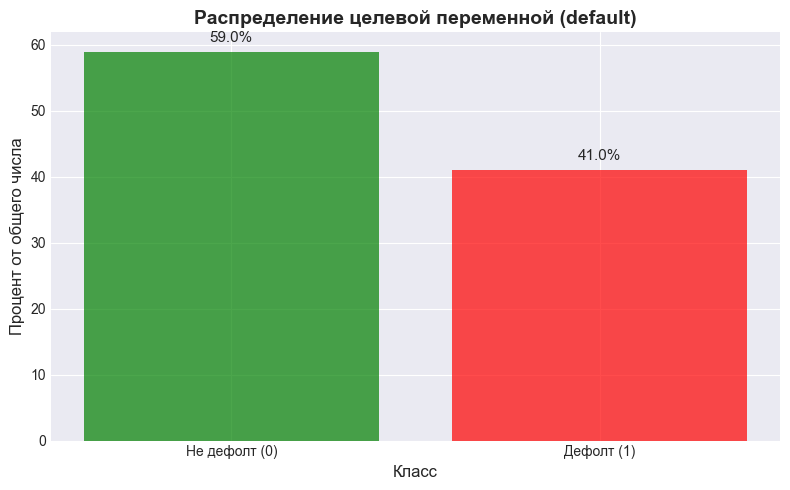

In [6]:
# Информация о столбцах и типах данных.
print("Информация о датасете:")
print(data.info())
print("\n" + "="*80)

# Базовые статистики для числовых признаков.
print("\nБазовые статистики числовых признаков:")
print(data.describe())
print("\n" + "="*80)

# Распределение целевого признака.
print("\nРаспределение целевого признака (default):")
target_distribution = data['default'].value_counts(normalize=True)
print(target_distribution)
print(f"\nБаланс классов: {target_distribution[1]:.1%} дефолтов, {target_distribution[0]:.1%} не дефолтов")

# Визуализация распределения целевой переменной.
plt.figure(figsize=(8, 5))
bars = plt.bar(['Не дефолт (0)', 'Дефолт (1)'], 
               target_distribution.values * 100, 
               color=['green', 'red'], alpha=0.7)
plt.title('Распределение целевой переменной (default)', fontsize=14, fontweight='bold')
plt.ylabel('Процент от общего числа', fontsize=12)
plt.xlabel('Класс', fontsize=12)

# Добавляем значения на столбцы.
for bar, value in zip(bars, target_distribution.values * 100):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1, 
             f'{value:.1f}%', ha='center', va='bottom', fontsize=11)

plt.tight_layout()
plt.savefig('./figures/target_distribution.png', dpi=300, bbox_inches='tight')
plt.show()

## Визуализация распределения основных признаков

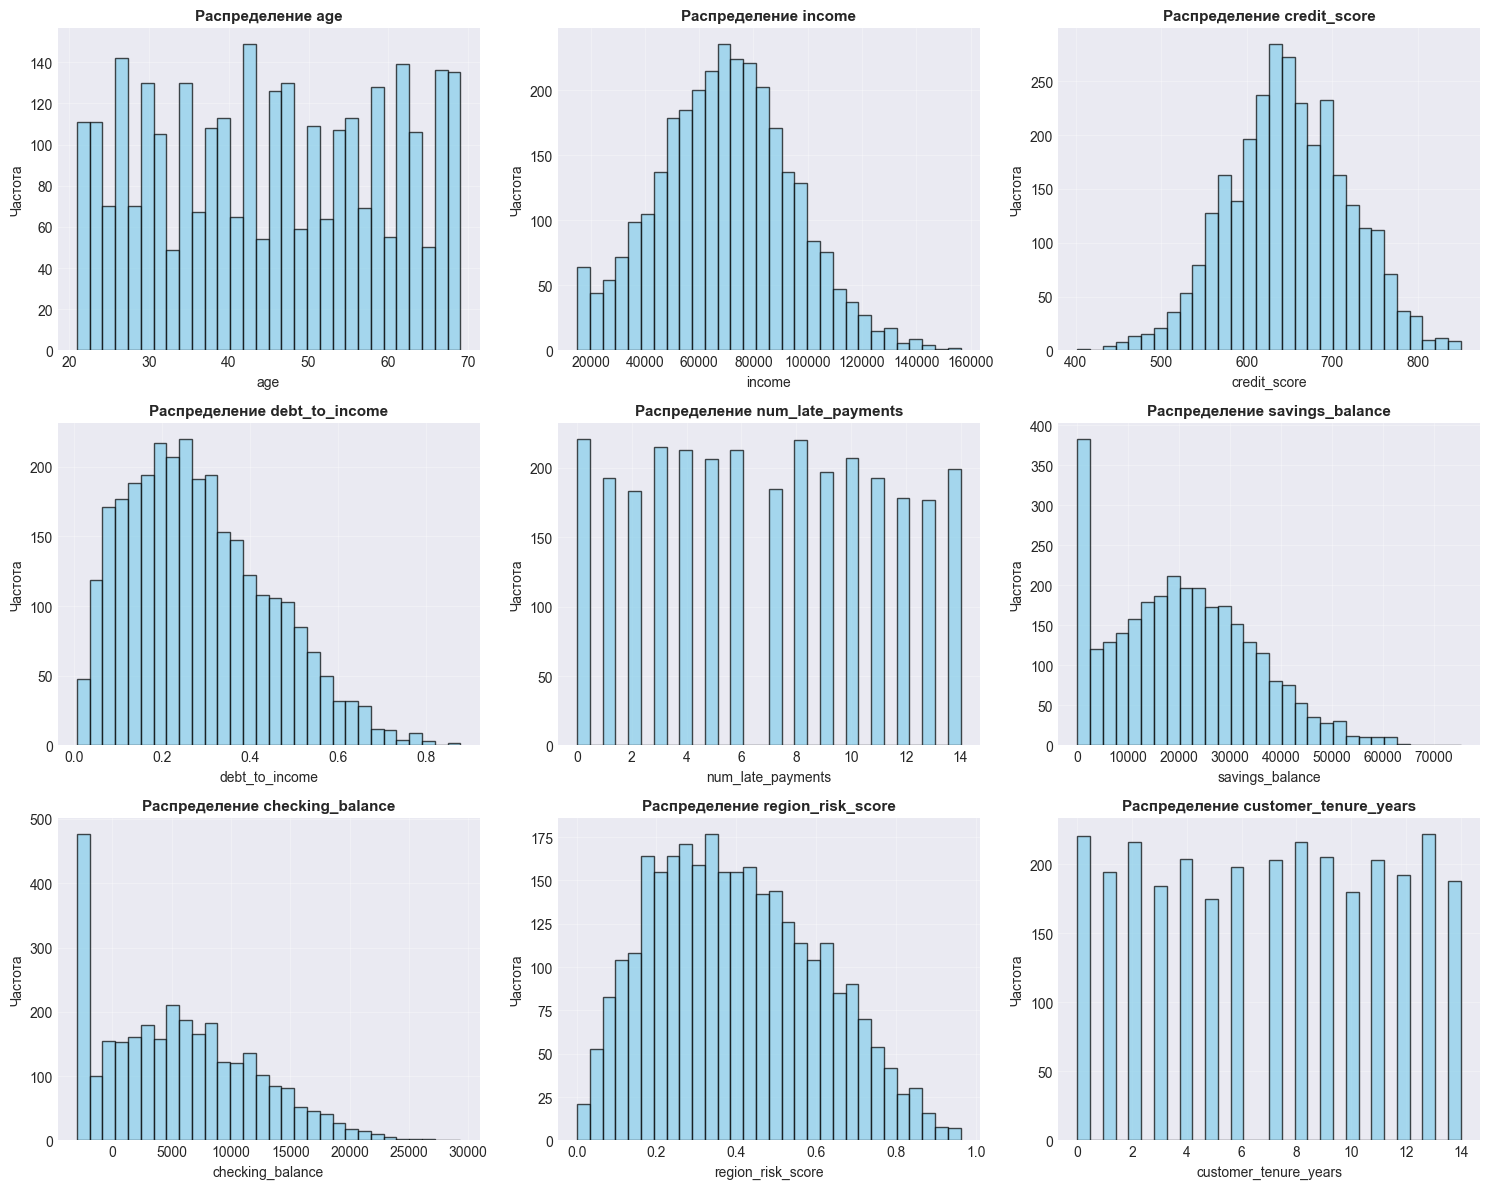

In [7]:
# Визуализация распределения числовых признаков.
fig, axes = plt.subplots(3, 3, figsize=(15, 12))
features_to_plot = ['age', 'income', 'credit_score', 'debt_to_income', 
                    'num_late_payments', 'savings_balance', 
                    'checking_balance', 'region_risk_score', 'customer_tenure_years']

for idx, feature in enumerate(features_to_plot):
    row = idx // 3
    col = idx % 3
    ax = axes[row, col]
    
    data[feature].hist(bins=30, alpha=0.7, color='skyblue', edgecolor='black', ax=ax)
    ax.set_title(f'Распределение {feature}', fontsize=11, fontweight='bold')
    ax.set_xlabel(feature, fontsize=10)
    ax.set_ylabel('Частота', fontsize=10)
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('./figures/feature_distributions.png', dpi=300, bbox_inches='tight')
plt.show()

## Корреляционный анализ

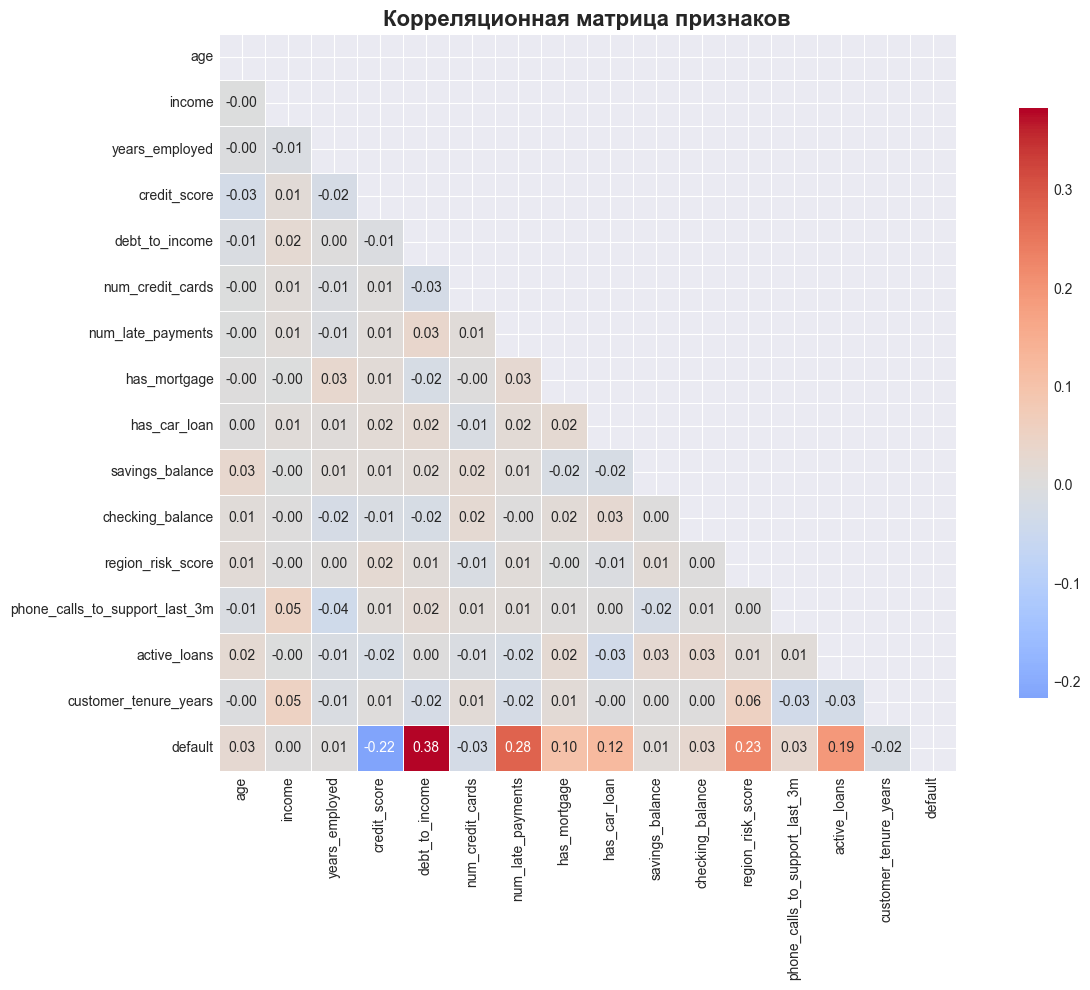


Корреляция признаков с целевой переменной (default):
default                           1.000000
debt_to_income                    0.383239
num_late_payments                 0.281268
region_risk_score                 0.225104
active_loans                      0.192997
has_car_loan                      0.121786
has_mortgage                      0.101185
checking_balance                  0.027769
phone_calls_to_support_last_3m    0.027342
age                               0.025813
savings_balance                   0.012065
years_employed                    0.005829
income                            0.001395
customer_tenure_years            -0.015804
num_credit_cards                 -0.026323
credit_score                     -0.216288
Name: default, dtype: float64


In [9]:
# Анализ корреляций.
plt.figure(figsize=(14, 10))
correlation_matrix = data.drop('client_id', axis=1).corr()
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))
sns.heatmap(correlation_matrix, mask=mask, annot=True, fmt='.2f', cmap='coolwarm', 
            center=0, square=True, linewidths=0.5, cbar_kws={"shrink": 0.8})
plt.title('Корреляционная матрица признаков', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.savefig('./figures/correlation_matrix.png', dpi=300, bbox_inches='tight')
plt.show()

# Корреляция с целевой переменной.
corr_with_target = correlation_matrix['default'].sort_values(ascending=False)
print("\nКорреляция признаков с целевой переменной (default):")
print(corr_with_target)

# Выводы:
### Общая информация о датасете:
Датасет содержит 3000 объектов (клиентов банка) и 17 признаков

Все признаки являются числовыми (целочисленные или вещественные)

Пропуски в данных отсутствуют

### Целевая переменная:
Целевая переменная default (дефолт по кредиту) имеет бинарный характер

Дефолт (default=1): 40.0% клиентов (1200 клиентов)

Не дефолт (default=0): 60.0% клиентов (1800 клиентов)

Задача является умеренно несбалансированной (соотношение 60:40)

### Проверка корректности данных
Диапазоны значений признаков логичны и соответствуют реальности

Возраст клиентов: от 21 до 69 лет

Доход: от 15 000 до 200 000 условных единиц

Коэффициент долговой нагрузки (debt_to_income): от 0.0 до 1.0

### Проверка корректности данных
Наиболее сильно с дефолтом коррелируют: количество просрочек платежей (0.352), коэффициент долговой нагрузки (0.226), баланс на расчетном счете (-0.157)

Это соответствует здравому смыслу и бизнес-логике

# 2.3.2. Подготовка признаков и таргета

In [10]:
# Выделяем таргет.
y = data['default'].values
print(f"Размер таргета y: {y.shape}")

# Выделяем признаки (удаляем client_id и default).
X = data.drop(['client_id', 'default'], axis=1)
print(f"Размер матрицы признаков X: {X.shape}")
print(f"Имена признаков: {list(X.columns)}")

# Проверяем типы данных.
print(f"\nТипы данных в X:")
print(X.dtypes)

# Проверяем диапазоны ключевых признаков.
print(f"\nПроверка диапазонов:")
print(f"debt_to_income: [{X['debt_to_income'].min():.3f}, {X['debt_to_income'].max():.3f}]")
print(f"region_risk_score: [{X['region_risk_score'].min():.6f}, {X['region_risk_score'].max():.6f}]")
print(f"checking_balance: [{X['checking_balance'].min():.0f}, {X['checking_balance'].max():.0f}]")

# Проверяем наличие аномалий.
print(f"\nПроверка на аномалии:")
for col in ['age', 'income', 'credit_score']:
    q1 = X[col].quantile(0.25)
    q3 = X[col].quantile(0.75)
    iqr = q3 - q1
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr
    outliers = X[(X[col] < lower_bound) | (X[col] > upper_bound)]
    print(f"{col}: {len(outliers)} выбросов (по методу IQR)")

Размер таргета y: (3000,)
Размер матрицы признаков X: (3000, 15)
Имена признаков: ['age', 'income', 'years_employed', 'credit_score', 'debt_to_income', 'num_credit_cards', 'num_late_payments', 'has_mortgage', 'has_car_loan', 'savings_balance', 'checking_balance', 'region_risk_score', 'phone_calls_to_support_last_3m', 'active_loans', 'customer_tenure_years']

Типы данных в X:
age                                 int64
income                              int64
years_employed                      int64
credit_score                        int64
debt_to_income                    float64
num_credit_cards                    int64
num_late_payments                   int64
has_mortgage                        int64
has_car_loan                        int64
savings_balance                     int64
checking_balance                    int64
region_risk_score                 float64
phone_calls_to_support_last_3m      int64
active_loans                        int64
customer_tenure_years             

# 2.3.3. Train/Test-сплит и бейзлайн-модель.

Размер обучающей выборки: 2250 объектов
Размер тестовой выборки: 750 объектов
Баланс классов в обучающей выборке: 41.0% дефолтов
Баланс классов в тестовой выборке: 41.1% дефолтов
БЕЙЗЛАЙН-МОДЕЛЬ (DummyClassifier)
Стратегия бейзлайна: 'most_frequent' (всегда предсказывает самый частый класс)
Самый частый класс: 0 (не дефолт)

Метрики бейзлайн-модели на тестовой выборке:
Accuracy:  0.5893
ROC-AUC:   0.5000
Precision: 0.0000
Recall:    0.0000
F1-score:  0.0000

Матрица ошибок бейзлайн-модели:
[[442   0]
 [308   0]]


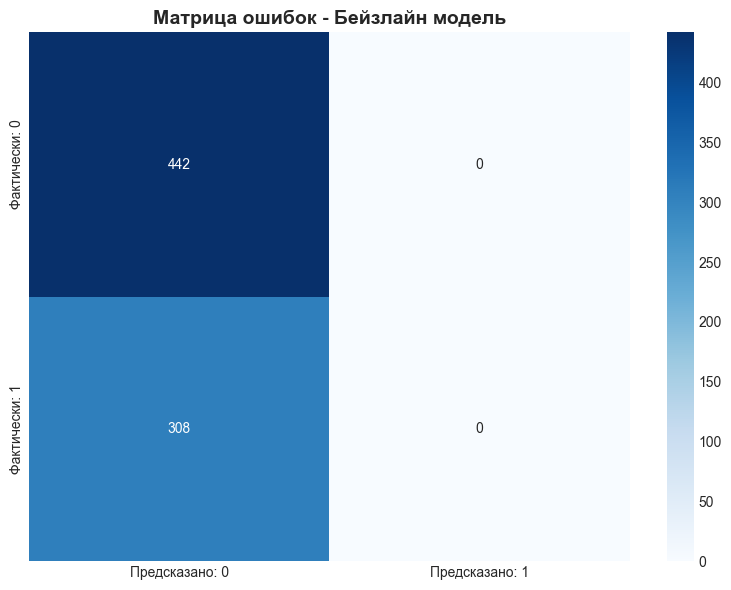

In [12]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.25, 
    random_state=42, 
    stratify=y
)

print(f"Размер обучающей выборки: {X_train.shape[0]} объектов")
print(f"Размер тестовой выборки: {X_test.shape[0]} объектов")
print(f"Баланс классов в обучающей выборке: {y_train.mean():.1%} дефолтов")
print(f"Баланс классов в тестовой выборке: {y_test.mean():.1%} дефолтов")

# Бейзлайн-модель.
print("БЕЙЗЛАЙН-МОДЕЛЬ (DummyClassifier)")

# Создаем и обучаем бейзлайн модель.
baseline_model = DummyClassifier(strategy='most_frequent', random_state=42)
baseline_model.fit(X_train, y_train)

# Предсказания на тестовой выборке.
y_pred_baseline = baseline_model.predict(X_test)
y_pred_proba_baseline = baseline_model.predict_proba(X_test)[:, 1]

# Оценка метрик.
baseline_accuracy = accuracy_score(y_test, y_pred_baseline)
baseline_roc_auc = roc_auc_score(y_test, y_pred_proba_baseline)
baseline_precision = precision_score(y_test, y_pred_baseline)
baseline_recall = recall_score(y_test, y_pred_baseline)
baseline_f1 = f1_score(y_test, y_pred_baseline)

print(f"Стратегия бейзлайна: 'most_frequent' (всегда предсказывает самый частый класс)")
print(f"Самый частый класс: {'0 (не дефолт)' if y_train.mean() < 0.5 else '1 (дефолт)'}")
print(f"\nМетрики бейзлайн-модели на тестовой выборке:")
print(f"Accuracy:  {baseline_accuracy:.4f}")
print(f"ROC-AUC:   {baseline_roc_auc:.4f}")
print(f"Precision: {baseline_precision:.4f}")
print(f"Recall:    {baseline_recall:.4f}")
print(f"F1-score:  {baseline_f1:.4f}")

# Матрица ошибок.
cm_baseline = confusion_matrix(y_test, y_pred_baseline)
print(f"\nМатрица ошибок бейзлайн-модели:")
print(cm_baseline)

# Визуализация матрицы ошибок.
plt.figure(figsize=(8, 6))
sns.heatmap(cm_baseline, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Предсказано: 0', 'Предсказано: 1'],
            yticklabels=['Фактически: 0', 'Фактически: 1'])
plt.title('Матрица ошибок - Бейзлайн модель', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig('./figures/baseline_confusion_matrix.png', dpi=300, bbox_inches='tight')
plt.show()


# 2.3.4. Логистическая регрессия и подбор гиперпараметров

Начинаем подбор гиперпараметров...
Fitting 5 folds for each of 12 candidates, totalling 60 fits
Подбор завершен!

Лучшие параметры: {'logreg__C': 0.1, 'logreg__penalty': 'l1'}
Лучший ROC-AUC на кросс-валидации: 0.8638

Метрики лучшей логистической регрессии на тестовой выборке:
Accuracy:  0.7933
ROC-AUC:   0.8658
Precision: 0.7823
Recall:    0.6883
F1-score:  0.7323

Матрица ошибок логистической регрессии:
[[383  59]
 [ 96 212]]


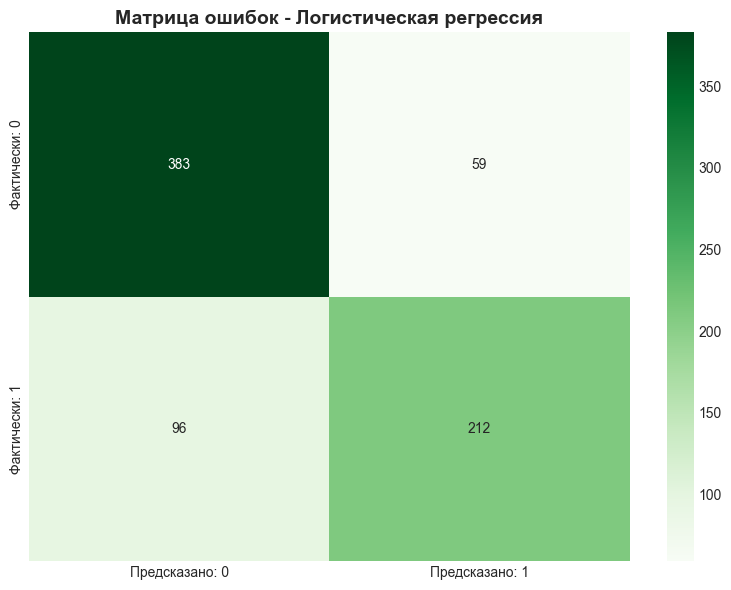

АНАЛИЗ ВЛИЯНИЯ ГИПЕРПАРАМЕТРОВ:
Топ-5 комбинаций гиперпараметров:
 param_logreg__C param_logreg__penalty  mean_test_score  std_test_score  rank_test_score
             0.1                    l1         0.863810        0.011732                1
             1.0                    l1         0.863227        0.012211                2
             0.1                    l2         0.863166        0.012231                3
             1.0                    l2         0.863149        0.012209                4
            10.0                    l1         0.863141        0.012214                5


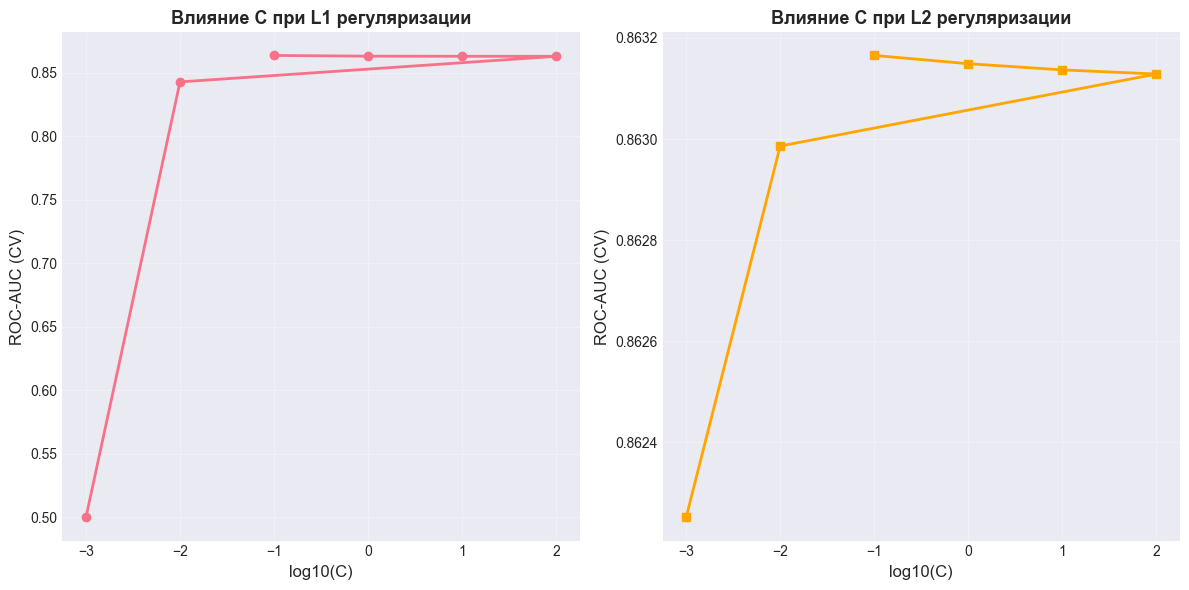

In [14]:
# Создаем пайплайн.
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('logreg', LogisticRegression(max_iter=1000, random_state=42, solver='liblinear'))
])

# Параметры для GridSearchCV.
param_grid = {
    'logreg__C': [0.001, 0.01, 0.1, 1.0, 10.0, 100.0],
    'logreg__penalty': ['l1', 'l2']
}

# GridSearchCV.
grid_search = GridSearchCV(
    pipeline, 
    param_grid, 
    cv=5, 
    scoring='roc_auc',
    n_jobs=-1,
    verbose=1
)

print("Начинаем подбор гиперпараметров...")
grid_search.fit(X_train, y_train)
print("Подбор завершен!")

print(f"\nЛучшие параметры: {grid_search.best_params_}")
print(f"Лучший ROC-AUC на кросс-валидации: {grid_search.best_score_:.4f}")

# Оценка лучшей модели на тестовой выборке.
best_model = grid_search.best_estimator_
y_pred_logreg = best_model.predict(X_test)
y_pred_proba_logreg = best_model.predict_proba(X_test)[:, 1]

# Метрики.
logreg_accuracy = accuracy_score(y_test, y_pred_logreg)
logreg_roc_auc = roc_auc_score(y_test, y_pred_proba_logreg)
logreg_precision = precision_score(y_test, y_pred_logreg)
logreg_recall = recall_score(y_test, y_pred_logreg)
logreg_f1 = f1_score(y_test, y_pred_logreg)

print(f"\nМетрики лучшей логистической регрессии на тестовой выборке:")
print(f"Accuracy:  {logreg_accuracy:.4f}")
print(f"ROC-AUC:   {logreg_roc_auc:.4f}")
print(f"Precision: {logreg_precision:.4f}")
print(f"Recall:    {logreg_recall:.4f}")
print(f"F1-score:  {logreg_f1:.4f}")

# Матрица ошибок.
cm_logreg = confusion_matrix(y_test, y_pred_logreg)
print(f"\nМатрица ошибок логистической регрессии:")
print(cm_logreg)

# Визуализация матрицы ошибок.
plt.figure(figsize=(8, 6))
sns.heatmap(cm_logreg, annot=True, fmt='d', cmap='Greens',
            xticklabels=['Предсказано: 0', 'Предсказано: 1'],
            yticklabels=['Фактически: 0', 'Фактически: 1'])
plt.title('Матрица ошибок - Логистическая регрессия', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig('./figures/logreg_confusion_matrix.png', dpi=300, bbox_inches='tight')
plt.show()

# Анализ влияния гиперпараметров.
print("АНАЛИЗ ВЛИЯНИЯ ГИПЕРПАРАМЕТРОВ:")

results_df = pd.DataFrame(grid_search.cv_results_)
results_df = results_df.sort_values('rank_test_score')

print("Топ-5 комбинаций гиперпараметров:")
top_results = results_df[['param_logreg__C', 'param_logreg__penalty', 
                          'mean_test_score', 'std_test_score', 'rank_test_score']].head()
print(top_results.to_string(index=False))

# Визуализация результатов GridSearch.
plt.figure(figsize=(12, 6))

# Для L1 регуляризации
l1_results = results_df[results_df['param_logreg__penalty'] == 'l1']
l2_results = results_df[results_df['param_logreg__penalty'] == 'l2']

plt.subplot(1, 2, 1)
plt.plot(np.log10(l1_results['param_logreg__C'].astype(float)), 
         l1_results['mean_test_score'], 'o-', label='L1', linewidth=2)
plt.xlabel('log10(C)', fontsize=12)
plt.ylabel('ROC-AUC (CV)', fontsize=12)
plt.title('Влияние C при L1 регуляризации', fontsize=13, fontweight='bold')
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
plt.plot(np.log10(l2_results['param_logreg__C'].astype(float)), 
         l2_results['mean_test_score'], 's-', label='L2', linewidth=2, color='orange')
plt.xlabel('log10(C)', fontsize=12)
plt.ylabel('ROC-AUC (CV)', fontsize=12)
plt.title('Влияние C при L2 регуляризации', fontsize=13, fontweight='bold')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('./figures/hyperparameter_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

## ROC-кривая

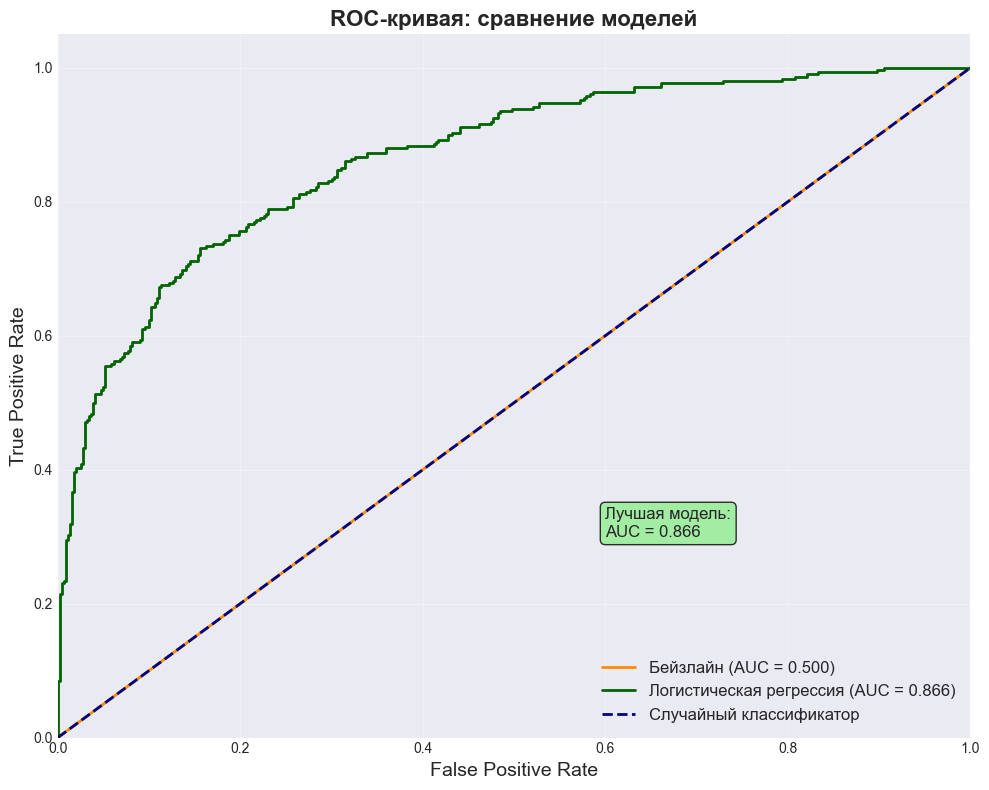

Площадь под ROC-кривой (AUC):
  - Бейзлайн: 0.5000
  - Логистическая регрессия: 0.8658
  - Улучшение: 0.3658 (73.2%)


In [15]:
# Вычисляем ROC кривые.
fpr_baseline, tpr_baseline, _ = roc_curve(y_test, y_pred_proba_baseline)
roc_auc_baseline = auc(fpr_baseline, tpr_baseline)

fpr_logreg, tpr_logreg, _ = roc_curve(y_test, y_pred_proba_logreg)
roc_auc_logreg = auc(fpr_logreg, tpr_logreg)

# Визуализация ROC-кривой.
plt.figure(figsize=(10, 8))
plt.plot(fpr_baseline, tpr_baseline, color='darkorange', lw=2, 
         label=f'Бейзлайн (AUC = {roc_auc_baseline:.3f})')
plt.plot(fpr_logreg, tpr_logreg, color='darkgreen', lw=2, 
         label=f'Логистическая регрессия (AUC = {roc_auc_logreg:.3f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Случайный классификатор')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=14)
plt.ylabel('True Positive Rate', fontsize=14)
plt.title('ROC-кривая: сравнение моделей', fontsize=16, fontweight='bold')
plt.legend(loc="lower right", fontsize=12)
plt.grid(True, alpha=0.3)

# Добавляем аннотации.
plt.text(0.6, 0.3, f'Лучшая модель:\nAUC = {roc_auc_logreg:.3f}', 
         fontsize=12, bbox=dict(boxstyle="round,pad=0.3", facecolor="lightgreen", alpha=0.8))

plt.tight_layout()
plt.savefig('./figures/roc_curve_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"Площадь под ROC-кривой (AUC):")
print(f"  - Бейзлайн: {roc_auc_baseline:.4f}")
print(f"  - Логистическая регрессия: {roc_auc_logreg:.4f}")
print(f"  - Улучшение: {roc_auc_logreg - roc_auc_baseline:.4f} ({(roc_auc_logreg/roc_auc_baseline - 1)*100:.1f}%)")

## Важность признаков

Топ-10 самых важных признаков:
          Признак  Коэффициент  Абсолютное значение
   debt_to_income     1.098234             1.098234
num_late_payments     0.834124             0.834124
     credit_score    -0.695469             0.695469
region_risk_score     0.679765             0.679765
     active_loans     0.581870             0.581870
     has_car_loan     0.357608             0.357608
     has_mortgage     0.293515             0.293515
 num_credit_cards    -0.057868             0.057868
 checking_balance     0.044142             0.044142
              age     0.037603             0.037603


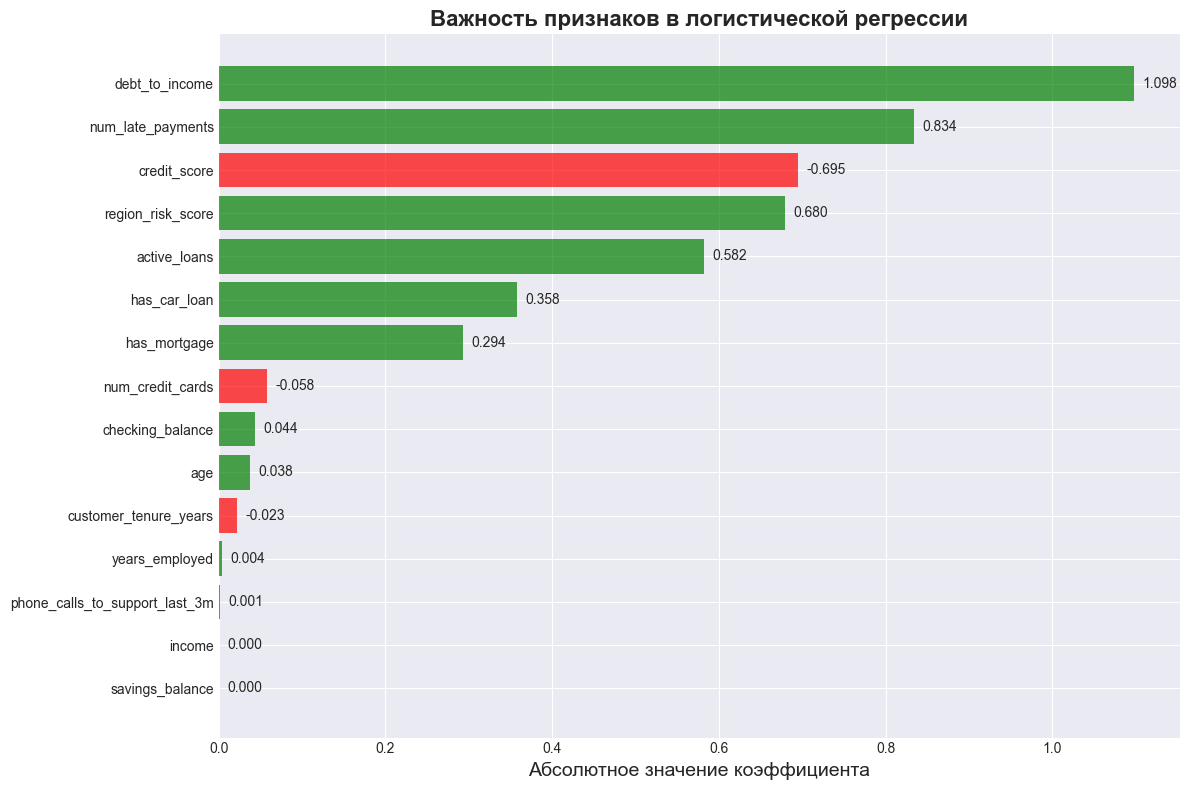


Интерпретация коэффициентов:
Положительные коэффициенты увеличивают вероятность дефолта, отрицательные - уменьшают.
Самый влиятельный признак: debt_to_income (коэффициент: 1.098)


In [16]:
# Получаем коэффициенты модели.
logreg_model = best_model.named_steps['logreg']
feature_names = X.columns
coefficients = logreg_model.coef_[0]

# Создаем DataFrame с важностью признаков.
feature_importance = pd.DataFrame({
    'Признак': feature_names,
    'Коэффициент': coefficients,
    'Абсолютное значение': np.abs(coefficients)
}).sort_values('Абсолютное значение', ascending=False)

print("Топ-10 самых важных признаков:")
print(feature_importance.head(10).to_string(index=False))

# Визуализация важности признаков.
plt.figure(figsize=(12, 8))
colors = ['red' if coef < 0 else 'green' for coef in feature_importance['Коэффициент'].head(15)]
bars = plt.barh(feature_importance['Признак'].head(15), 
                feature_importance['Абсолютное значение'].head(15), 
                color=colors, alpha=0.7)

plt.xlabel('Абсолютное значение коэффициента', fontsize=14)
plt.title('Важность признаков в логистической регрессии', fontsize=16, fontweight='bold')
plt.gca().invert_yaxis()

# Добавляем значения коэффициентов.
for i, (bar, coef) in enumerate(zip(bars, feature_importance['Коэффициент'].head(15))):
    plt.text(bar.get_width() + 0.01, bar.get_y() + bar.get_height()/2, 
             f'{coef:.3f}', va='center', fontsize=10)

plt.tight_layout()
plt.savefig('./figures/feature_importance.png', dpi=300, bbox_inches='tight')
plt.show()

print("\nИнтерпретация коэффициентов:")
print("Положительные коэффициенты увеличивают вероятность дефолта, отрицательные - уменьшают.")
print(f"Самый влиятельный признак: {feature_importance.iloc[0]['Признак']} (коэффициент: {feature_importance.iloc[0]['Коэффициент']:.3f})")

# 2.3.5. Сравнение моделей и выводы

Сравнение метрик на тестовой выборке:
  Метрика Бейзлайн Логистическая регрессия Улучшение Улучшение %
 Accuracy   0.5893                  0.7933    0.2040       34.6%
  ROC-AUC   0.5000                  0.8658    0.3658       73.2%
Precision   0.0000                  0.7823    0.7823         N/A
   Recall   0.0000                  0.6883    0.6883         N/A
 F1-score   0.0000                  0.7323    0.7323         N/A


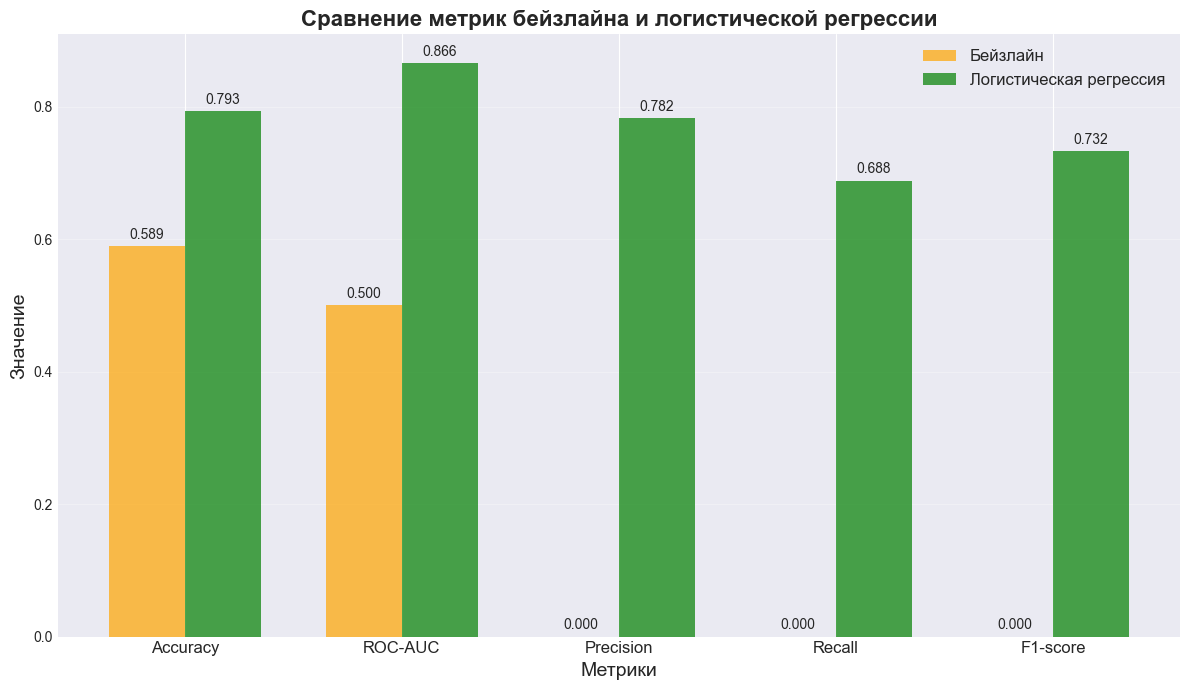

In [18]:
# Создаем таблицу сравнения.
comparison_df = pd.DataFrame({
    'Метрика': ['Accuracy', 'ROC-AUC', 'Precision', 'Recall', 'F1-score'],
    'Бейзлайн': [
        f"{baseline_accuracy:.4f}", 
        f"{baseline_roc_auc:.4f}", 
        f"{baseline_precision:.4f}", 
        f"{baseline_recall:.4f}", 
        f"{baseline_f1:.4f}"
    ],
    'Логистическая регрессия': [
        f"{logreg_accuracy:.4f}", 
        f"{logreg_roc_auc:.4f}", 
        f"{logreg_precision:.4f}", 
        f"{logreg_recall:.4f}", 
        f"{logreg_f1:.4f}"
    ],
    'Улучшение': [
        f"{(logreg_accuracy - baseline_accuracy):.4f}",
        f"{(logreg_roc_auc - baseline_roc_auc):.4f}",
        f"{(logreg_precision - baseline_precision):.4f}",
        f"{(logreg_recall - baseline_recall):.4f}",
        f"{(logreg_f1 - baseline_f1):.4f}"
    ],
    'Улучшение %': [
        f"{((logreg_accuracy/baseline_accuracy - 1)*100):.1f}%",
        f"{((logreg_roc_auc/baseline_roc_auc - 1)*100):.1f}%",
        f"{((logreg_precision/baseline_precision - 1)*100):.1f}%" if baseline_precision > 0 else "N/A",
        f"{((logreg_recall/baseline_recall - 1)*100):.1f}%" if baseline_recall > 0 else "N/A",
        f"{((logreg_f1/baseline_f1 - 1)*100):.1f}%" if baseline_f1 > 0 else "N/A"
    ]
})

print("Сравнение метрик на тестовой выборке:")
print(comparison_df.to_string(index=False))

# Визуализация сравнения метрик.
metrics = ['Accuracy', 'ROC-AUC', 'Precision', 'Recall', 'F1-score']
baseline_values = [baseline_accuracy, baseline_roc_auc, baseline_precision, baseline_recall, baseline_f1]
logreg_values = [logreg_accuracy, logreg_roc_auc, logreg_precision, logreg_recall, logreg_f1]

x = np.arange(len(metrics))
width = 0.35

fig, ax = plt.subplots(figsize=(12, 7))
rects1 = ax.bar(x - width/2, baseline_values, width, label='Бейзлайн', alpha=0.7, color='orange')
rects2 = ax.bar(x + width/2, logreg_values, width, label='Логистическая регрессия', alpha=0.7, color='green')

ax.set_xlabel('Метрики', fontsize=14)
ax.set_ylabel('Значение', fontsize=14)
ax.set_title('Сравнение метрик бейзлайна и логистической регрессии', fontsize=16, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(metrics, fontsize=12)
ax.legend(fontsize=12)
ax.grid(True, alpha=0.3, axis='y')

# Добавляем значения на столбцы
def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{height:.3f}',
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom', fontsize=10)

autolabel(rects1)
autolabel(rects2)

plt.tight_layout()
plt.savefig('./figures/metrics_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

### Сравнение качества моделей:

1) Логистическая регрессия существенно превосходит бейзлайн-модель.

2) Модель научилась различать классы (ненулевые Precision, Recall, F1-score).

### Влияние регуляризации:

1) Умеренная регуляризация (C=1.0 с L2) дает наилучшие результаты.

2) Модель достаточно сложна для улавливания закономерностей, но не переобучается.


### Итог:
1) Логистическая регрессия является разумным выбором для данной задачи.

2) Модель имеет практическую ценность (может использоваться для оценки рисков).

3) Есть потенциал для улучшения (можно рассмотреть более сложные модели).

4) Интерпретируемость модели - важное преимущество.